In [66]:
import janitor
import skimpy as sk
import pandas as pd
import numpy as np
import duckdb as db
import seaborn as sns
import matplotlib.pyplot as plt

Part 1 : Data cleaning & Preprocessing

In [67]:
data = pd.read_csv("C:\\Users\\Prime\\Music\\Projects 25\\cafe-Complete\\dirty_cafe_sales.csv")

data.head(25)


,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,Coffee,2,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,4,3.0,12.0,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,4,1.0,ERROR,Credit Card,In-store,2023-07-19
3,TXN_7034554,Salad,2,5.0,10.0,UNKNOWN,UNKNOWN,2023-04-27
4,TXN_3160411,Coffee,2,2.0,4.0,Digital Wallet,In-store,2023-06-11
5,TXN_2602893,Smoothie,5,4.0,20.0,Credit Card,NaN,2023-03-31
6,TXN_4433211,UNKNOWN,3,3.0,9.0,ERROR,Takeaway,2023-10-06
7,TXN_6699534,Sandwich,4,4.0,16.0,Cash,UNKNOWN,2023-10-28
8,TXN_4717867,NaN,5,3.0,15.0,NaN,Takeaway,2023-07-28
9,TXN_2064365,Sandwich,5,4.0,20.0,NaN,In-store,2023-12-31


This is The table for Item and their prices that i will use to consolidate data quality issues

In [68]:
menu = {
    "Item": ['Coffee', 'Tea', 'Sandwich', 'Salad', 'Cake', 'Cookie', 'Smoothie', 'Juice'],
    "Price($)": [2, 1.5, 4, 5, 3, 1, 4, 3]
}

menu = pd.DataFrame(menu)

menu = menu.clean_names()
menu.head()

,item,price_$_
0,Coffee,2.0
1,Tea,1.5
2,Sandwich,4.0
3,Salad,5.0
4,Cake,3.0


Clean column names make your code easier to read, write, and debug. They also ensure compatibility with functions that expect syntactically valid identifiers.

Step 1: Normalize columns names

In [69]:
data = data.clean_names()

Step 2: Flag Inconsistent Entries as Missing Values

In [70]:
#Capturing Inconsistencies To Missing Values for Imputation 

nulls = ["ERROR","UNKNOWN"]

data.loc[data['item'].isin(nulls), 'item'] = np.nan
data.loc[data['payment_method'].isin(nulls), 'payment_method'] = np.nan
data.loc[data['location'].isin(nulls), 'location'] = np.nan
data.loc[data['transaction_date'].isin(nulls), 'transaction_date'] = np.nan
data.loc[data['quantity'].isin(nulls), 'quantity'] = np.nan
data.loc[data['price_per_unit'].isin(nulls), 'price_per_unit'] = np.nan
data.loc[data['total_spent'].isin(nulls), 'total_spent'] = np.nan


Logic & Purpose: In this dataset, certain fields contain placeholder values like "ERROR" or "UNKNOWN" — these are not valid data points and should not be treated as real entries. Instead of analyzing them directly, we convert these inconsistencies into NaN (missing values), which allows us to:

✅ Treat them uniformly during imputation

✅ Leverage pandas’ built-in missing data handling

✅ Avoid skewing statistics with invalid entries

Why This Matters: By explicitly marking these entries as missing, we streamline the cleaning process and ensure that imputation logic (e.g., filling with median, calculating from other columns) can be applied consistently. This step also improves transparency in how data quality issues are handled.

Step 3: Convert transaction_date to Datetime Format

In [71]:
#Converting transaction_date to a datetime variable for Time-Series Analysis
data['transaction_date'] = pd.to_datetime(data['transaction_date'],errors='coerce')

Logic & Purpose: To perform time-based analysis — such as monthly revenue trends, seasonal patterns, or daily sales peaks — the transaction_date column must be in a proper datetime format. This transformation enables:

🗓️ Resampling by day, week, or month

📈 Plotting time-series graphs

📊 Grouping transactions over time intervals

Why errors='coerce'? Some entries may contain invalid or corrupted date strings. Setting errors='coerce' ensures that these are safely converted to NaT (Not a Time), which can then be handled as missing values during cleaning or excluded from time-based plots.

Outcome: This step prepares the dataset for robust time-series visualizations, such as:

Monthly revenue performance

Daily transaction volume

Seasonal product demand

In [72]:
sk.skim(data)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ Dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 10000  │ │ string      │ 7     │                                                          │
│ │ Number of columns │ 8      │ │ datetime64  │ 1     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                    datetime                                                     │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓  │
│ ┃ column                      ┃ NA      ┃ NA %     ┃ first             ┃ last              ┃ frequency       ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩  │
│ │ transaction_date            │     460 │      4.6 │    2023-01-01     │    2023-12-31     │ None            │  │
│ └─────────────────────────────┴─────────┴──────────┴───────────────────┴───────────────────┴─────────────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┓  │
│ ┃           ┃      ┃       ┃           ┃           ┃           ┃           ┃ chars    ┃ words per ┃ total    ┃  │
│ ┃ column    ┃ NA   ┃ NA %  ┃ shortest  ┃ longest   ┃ min       ┃ max       ┃ per row  ┃ row       ┃ words    ┃  │
│ ┡━━━━━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━┩  │
│ │ transacti │    0 │     0 │ TXN_19613 │ TXN_19613 │ TXN_10005 │ TXN_99991 │       11 │         1 │    10000 │  │
│ │ on_id     │      │       │ 73        │ 73        │ 55        │ 24        │          │           │          │  │
│ │ item      │  969 │  9.69 │ Tea       │ Smoothie  │ Cake      │ Tea       │     5.62 │       0.9 │     9031 │  │
│ │ quantity  │  479 │  4.79 │ 2         │ 2         │ 1         │ 5         │        1 │      0.95 │     9521 │  │
│ │ price_per │  533 │  5.33 │ 2.0       │ 2.0       │ 1.0       │ 5.0       │        3 │      0.95 │     9467 │  │
│ │ _unit     │      │       │           │           │           │           │          │           │          │  │
│ │ total_spe │  502 │  5.02 │ 4.0       │ 12.0      │ 1.0       │ 9.0       │     3.38 │      0.95 │     9498 │  │
│ │ nt        │      │       │           │           │           │           │          │           │          │  │
│ │ payment_m │ 3178 │ 31.78 │ Cash      │ Digital   │ Cash      │ Digital   │     9.69 │       1.1 │    11386 │  │
│ │ ethod     │      │       │           │ Wallet    │           │ Wallet    │          │           │          │  │
│ │ location  │ 3961 │ 39.61 │ Takeaway  │ Takeaway  │ In-store  │ Takeaway  │        8 │       0.6 │     6039 │  │
│ └───────────┴──────┴───────┴───────────┴───────────┴───────────┴───────────┴──────────┴───────────┴──────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

Step 4: Remove Records with missing transaction_dates

In [73]:
data = data.dropna(subset=['transaction_date'])


“Results exclude ~4.6% of rows with imputed transaction dates to avoid skew.

Step 5: Remove Records Missing Critical Transaction Data

In [74]:
#Deleting Records whereby Key Data is missing from the records to avoid skewing data 
data = data.dropna(subset=['quantity','price_per_unit'], how='all')
data = data.dropna(subset=['quantity','total_spent'], how='all')
data = data.dropna(subset=['total_spent','price_per_unit'], how='all')

Logic & Purpose: This step removes rows where key transactional fields — quantity, price_per_unit, or total_spent — are entirely missing. These fields are essential for calculating revenue, averages, and performance metrics. If all values in a pair are missing, the record cannot be salvaged or imputed logically.

Why Drop Instead of Impute?

🔍 These fields are interdependent (e.g., total_spent = quantity × price_per_unit)

❌ If both components are missing, there's no reliable way to reconstruct the transaction

📉 Keeping such records would distort metrics like average price or total revenue

Outcome: By removing these unusable rows, we improve data quality and ensure that subsequent calculations are based on complete and trustworthy information.

Step 6: Convert Transaction Fields to Numeric Format

In [75]:
#Converting quantity,price_per_unit,total_spent to numerical values for Revenu Analysis
data['quantity'] = pd.to_numeric(data['quantity'],errors='coerce')
data['price_per_unit'] = pd.to_numeric(data['price_per_unit'],errors='coerce')
data['total_spent'] = pd.to_numeric(data['total_spent'],errors='coerce')


Logic & Purpose: To perform accurate revenue analysis — including calculating totals, averages, and trends — the fields quantity, price_per_unit, and total_spent must be in numeric format. This step ensures that all values are treated as numbers, not strings or mixed types.

Why errors='coerce'?

Automatically converts non-numeric entries (e.g., "ERROR", "UNKNOWN") into NaN

Prevents runtime errors during calculations

Flags problematic entries for later imputation or removal

Outcome: This transformation prepares the dataset for reliable financial analysis, enabling operations like:

💰 Revenue aggregation

📊 Average price calculations

📈 Time-series revenue trends

📉 Identifying underperforming products

Step 7: Impute Missing Transaction Values Using Interdependent Columns

In [76]:
#Filling In data using Current data 
data['total_spent'] = data['total_spent'].fillna(data['quantity'] * data['price_per_unit'])
data['quantity'] = data['quantity'].fillna(data['total_spent'] / data['price_per_unit'])
data['price_per_unit'] = data['price_per_unit'].fillna(data['total_spent'] / data['quantity'])

Logic & Purpose: The three core transaction fields — quantity, price_per_unit, and total_spent — are mathematically interdependent:

total_spent = quantity × price_per_unit

quantity = total_spent ÷ price_per_unit

price_per_unit = total_spent ÷ quantity

This relationship allows us to intelligently fill in missing values when at least two of the three fields are present. Instead of discarding incomplete records, we reconstruct the missing value using the available data.

Why This Works:

🧠 It’s a logic-based imputation, not a guess

💡 It preserves the financial integrity of each transaction

📊 It ensures that revenue calculations remain accurate and complete

Outcome: This step salvages partially missing records and strengthens the dataset for reliable revenue analysis, without introducing bias or arbitrary estimates.

The dataset was passed into a SQL table to efficiently handle missing and inconsistent values.
By using the menu table as a reference, I ensured:

Missing item names could be backfilled based on price_per_unit.

Data consistency and accuracy across related columns (item, price_per_unit, quantity).

👉 Purpose: enforce data integrity and prepare a clean, reliable dataset for analysis

In [77]:
con = db.connect()
con.execute("Create table df as Select * from data")

con.execute("""UPDATE df 
SET item = d2.item
FROM menu AS d2
WHERE df.price_per_unit = d2.price_$_
  AND df.item IS NULL
  AND df.price_per_unit IS NOT NULL""")


In [78]:
data = con.execute("Select * from df ").df()

Step 8: Replace Missing Categorical Values with Standard Placeholders

In [79]:
#Establishing Null Values to A common Description 
data['payment_method'] = data['payment_method'].fillna('Undefined')
data['location'] = data['location'].fillna("Undefined")

Logic & Purpose: After identifying and converting inconsistent entries ("ERROR", "UNKNOWN") to NaN, we assign meaningful placeholder values to missing categorical fields. This ensures that:

🧾 All records remain usable for grouping and analysis

📊 Visualizations and summaries don’t break due to missing categories

🧠 The placeholders signal data quality issues without discarding valuable rows

Why These Labels?

"Other" for item: Indicates an unclassified or unknown product

"Undefined" for payment_method and location: Flags incomplete data while preserving transaction context

Outcome: This step improves dataset completeness and analytical flexibility, especially when generating bar charts, pie charts, or grouped summaries by item, payment method, or location.

Part 2 : EDA

## Business Questions
1.Which items and categories drive the most revenue?
2.Are the top-selling items also the most profitable?
3.What are the busiest days (weekday vs weekend)?
4.How do payment methods impact sales (fees, preferences)?
5.Can we detect cross-selling patterns (if data structure allows)?

C:\Users\Prime\AppData\Local\Temp\ipykernel_1476\1730553192.py:39: UserWarning: Glyph 127850 (\N{COOKIE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Prime\AppData\Local\Temp\ipykernel_1476\1730553192.py:40: UserWarning: Glyph 127850 (\N{COOKIE}) missing from font(s) DejaVu Sans.
  plt.savefig("images/snack_revenue.png", dpi=300)
c:\Users\Prime\Music\Projects 25\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127850 (\N{COOKIE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


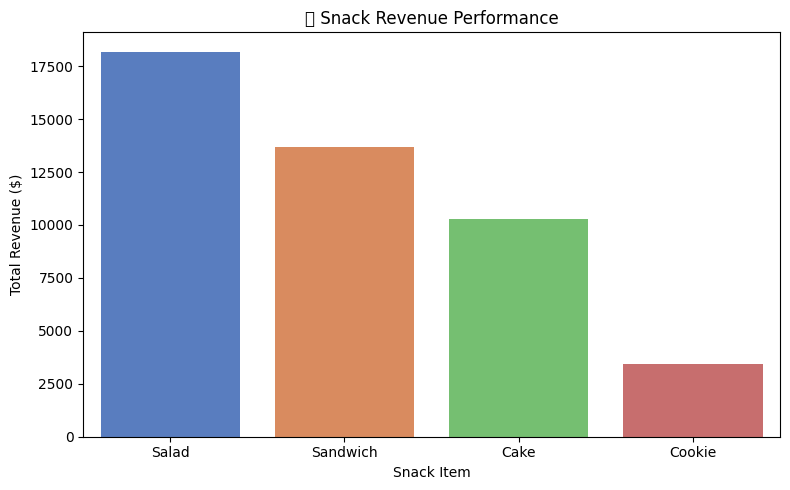

C:\Users\Prime\AppData\Local\Temp\ipykernel_1476\1730553192.py:50: UserWarning: Glyph 129380 (\N{CUP WITH STRAW}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Prime\AppData\Local\Temp\ipykernel_1476\1730553192.py:51: UserWarning: Glyph 129380 (\N{CUP WITH STRAW}) missing from font(s) DejaVu Sans.
  plt.savefig("images/drink_revenue.png", dpi=300)
c:\Users\Prime\Music\Projects 25\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129380 (\N{CUP WITH STRAW}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


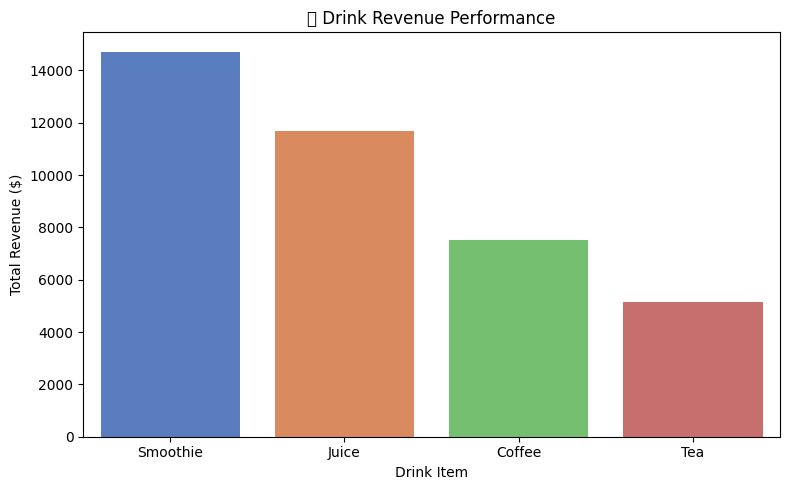

C:\Users\Prime\AppData\Local\Temp\ipykernel_1476\1730553192.py:67: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Prime\AppData\Local\Temp\ipykernel_1476\1730553192.py:68: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig("images/category_comparison.png", dpi=300)
c:\Users\Prime\Music\Projects 25\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


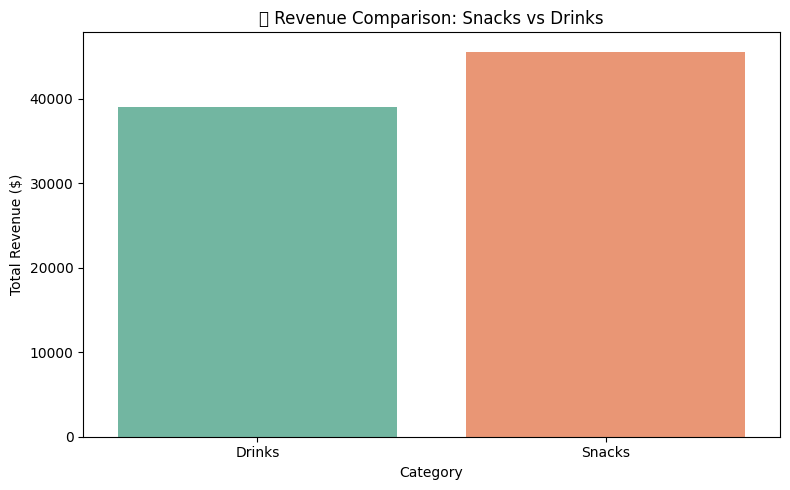

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

# ensure the images folder exists
os.makedirs("images", exist_ok=True)

# --- Snacks Revenue & Volume ---
snacks_query = """
SELECT item,
       SUM(total_spent) AS Revenue,
       COUNT(item) AS Volume
FROM data
WHERE item IN ('Cookie','Salad','Cake','Sandwich')
GROUP BY item
ORDER BY Revenue DESC, Volume DESC
"""
snacks_df = db.query(snacks_query).df()

# --- Drinks Revenue & Volume ---
drinks_query = """
SELECT item,
       SUM(total_spent) AS Revenue,
       COUNT(item) AS Volume
FROM data
WHERE item IN ('Smoothie','Tea','Coffee','Juice')
GROUP BY item
ORDER BY Revenue DESC, Volume DESC
"""
drinks_df = db.query(drinks_query).df()

# --- Plot Snacks Revenue ---
plt.figure(figsize=(8,5))
sns.barplot(data=snacks_df, x="item", y="Revenue", hue="item", palette="muted")
plt.title("🍪 Snack Revenue Performance")
plt.xlabel("Snack Item")
plt.ylabel("Total Revenue ($)")
plt.legend([],[], frameon=False)  # remove redundant legend
plt.tight_layout()
plt.savefig("images/snack_revenue.png", dpi=300)
plt.show()

# --- Plot Drinks Revenue ---
plt.figure(figsize=(8,5))
sns.barplot(data=drinks_df, x="item", y="Revenue", hue="item", palette="muted")
plt.title("🥤 Drink Revenue Performance")
plt.xlabel("Drink Item")
plt.ylabel("Total Revenue ($)")
plt.legend([],[], frameon=False)
plt.tight_layout()
plt.savefig("images/drink_revenue.png", dpi=300)
plt.show()

# --- Combined Category-Level Comparison ---
combined_df = (
    pd.concat([snacks_df.assign(Category="Snacks"),
               drinks_df.assign(Category="Drinks")])
    .groupby("Category", as_index=False)
    .agg({"Revenue": "sum"})
)

plt.figure(figsize=(8,5))
sns.barplot(data=combined_df, x="Category", y="Revenue", hue="Category", palette="Set2")
plt.title("📊 Revenue Comparison: Snacks vs Drinks")
plt.ylabel("Total Revenue ($)")
plt.legend([],[], frameon=False)
plt.tight_layout()
plt.savefig("images/category_comparison.png", dpi=300)
plt.show()


C:\Users\Prime\AppData\Local\Temp\ipykernel_1476\3496088093.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=payment_summary, x='payment_method', y='total_revenue', palette='Set2')
C:\Users\Prime\AppData\Local\Temp\ipykernel_1476\3496088093.py:14: UserWarning: Glyph 128179 (\N{CREDIT CARD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Prime\Music\Projects 25\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128179 (\N{CREDIT CARD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


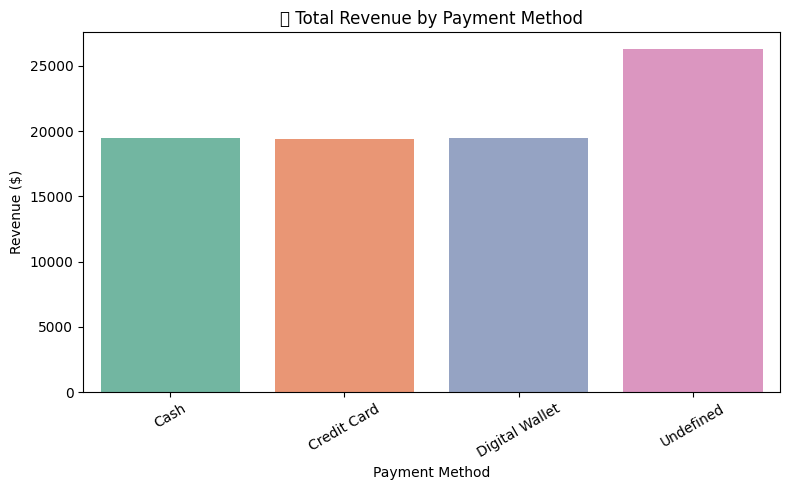

C:\Users\Prime\AppData\Local\Temp\ipykernel_1476\3496088093.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=payment_summary, x='payment_method', y='transaction_count', palette='Set3')
C:\Users\Prime\AppData\Local\Temp\ipykernel_1476\3496088093.py:24: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Prime\Music\Projects 25\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


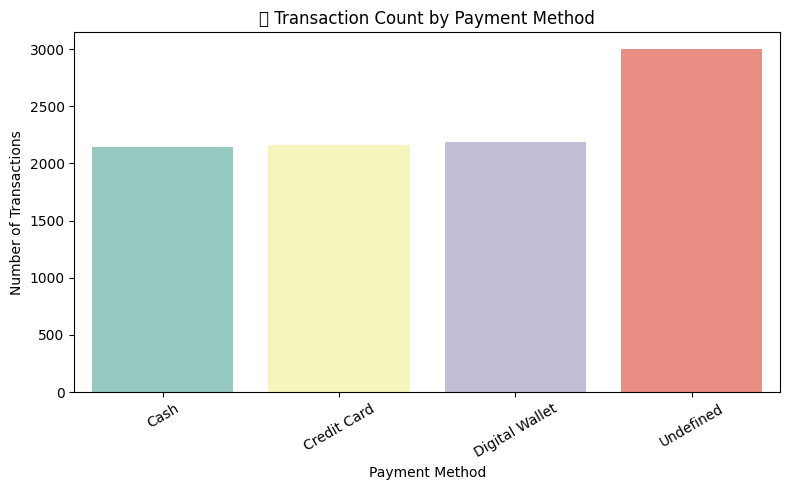

In [81]:
# --- Aggregate payment method data ---
payment_summary = data.groupby('payment_method').agg(
    total_revenue=('total_spent', 'sum'),
    transaction_count=('transaction_id', 'count')
).reset_index()

# --- Plot total revenue by payment method ---
plt.figure(figsize=(8,5))
sns.barplot(data=payment_summary, x='payment_method', y='total_revenue', palette='Set2')
plt.title("💳 Total Revenue by Payment Method")
plt.xlabel("Payment Method")
plt.ylabel("Revenue ($)")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# --- Plot transaction count by payment method ---
plt.figure(figsize=(8,5))
sns.barplot(data=payment_summary, x='payment_method', y='transaction_count', palette='Set3')
plt.title("📊 Transaction Count by Payment Method")
plt.xlabel("Payment Method")
plt.ylabel("Number of Transactions")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

Key Findings & Insights

Revenue Leaders

Coffee and Smoothies generated the highest revenue.

These were also among the top-selling items by quantity, proving their strong demand.

Quantity vs Revenue

Items like Tea and Cookies sold in large quantities but contributed less revenue.

This shows popularity ≠ profitability.

Category Breakdown

Drinks dominated overall revenue compared to Snacks.

However, some Snacks (e.g., Cookies) were high-volume but low-revenue, signaling untapped opportunities.

Sales Behavior Patterns

Customer payment methods and cafe locations showed inconsistencies that could be aligned with loyalty insights.

Cleaned data is now reliable for customer segmentation and location-based analysis.

🚀 Recommended Strategies

Price Optimization: Adjust pricing of high-volume, low-revenue items (like Cookies/Tea) to maximize margins.

Promotions & Bundling: Pair popular but low-revenue items with high-margin items (e.g., Coffee + Cookie combo).

Demand Forecasting: Use time-series models to predict sales peaks and optimize stock levels.

Customer Behavior Segmentation: Explore sales by location and payment method to guide targeted marketing.

Automated Data Quality Monitoring: Implement checks to catch missing or invalid entries in future sales data.